#**image segmentation of mould spores from grayscale microscope images**

**StarDist**

- cell segmentation models



## imports, mount drive and directory paths

In [1]:
##imports
# google drive
from google.colab import drive
#________________________________________________________________________________

# openCV and PIL
!pip install "opencv-python-headless<4.3"
import cv2 as cv
#________________________________________________________________________________

# tensorflow and keras
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from keras.layers import Input, Conv2D, Reshape
from keras.models import Model
from keras.models import Model, Sequential
from keras import backend as K


#________________________________________________________________________________

# albumentations
!pip install --upgrade git+https://github.com/albumentations-team/albumentations
import albumentations as A
#________________________________________________________________________________

# others 
import os
import numpy as np
from random import sample
from glob import glob
import matplotlib.pyplot as plt 
import pandas as pd

#________________________________________________________________________________

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import jaccard_score

#________________________________________________________________________________

#pytorch
from torch import stack
#_______________________________________________________________________________

#  stardist
!pip install stardist
from stardist.models import Config2D, StarDist2D, StarDistData2D
from stardist.plot import render_label
from stardist.matching import matching, matching_dataset
import stardist
from stardist import _draw_polygons
from stardist import fill_label_holes

# csbdeep
from csbdeep.utils.tf import keras_import
# from csbdeep.internals.nets import common_unet, custom_unet
# from csbdeep.internals.blocks import unet_block, resnet_block
from csbdeep.models import BaseModel, BaseConfig
from csbdeep.utils import normalize


#  stardist
!pip install stardist
from stardist.models import Config2D, StarDist2D, StarDistData2D
from stardist.plot import render_label
from stardist.matching import matching
import stardist
from stardist import _draw_polygons


     |████████████████████████████████| 21.6 MB 1.5 MB/s 
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-ihc6l8xl
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-ihc6l8xl
  Created wheel for albumentations: filename=albumentations-1.1.0-py3-none-any.whl size=112723 sha256=5a9d47c7d9bbafdbc6db5042f89b4cf4eaf1de73a3e6b796114be2bb248ad794
  Stored in directory: /tmp/pip-ephem-wheel-cache-3uyq9epy/wheels/3a/25/ed/ec3b518e7a332d7f0a3bb37c280e1b784cf2f79b94b3c7d00b
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
     |████████████████████████████████| 3.0 MB 5.3 MB/s 
     |████████████████████████████████| 73 kB 2.0 MB/s 
     |████████████████████████████████| 2.9 MB 23.0 MB/s 
  Attempting uninstall: h5py
    Found existing i

In [2]:
## if gpu is on use gpu
if_gpu = tf.test.gpu_device_name()
use_gpu = False
if if_gpu == '/device:GPU:0':
  !pip install pyopencl
  import pyopencl
  !pip install gputools
  import gputools
  use_gpu = True

use_gpu

     |████████████████████████████████| 884 kB 5.3 MB/s 
     |████████████████████████████████| 69 kB 7.0 MB/s 
  Created wheel for pytools: filename=pytools-2022.1.7-py2.py3-none-any.whl size=64772 sha256=034b3a25a07e9fd8fda4af9f52ab232dfaa01990e9ae98f348ca86cebdb138b9
  Stored in directory: /root/.cache/pip/wheels/24/c3/8d/9b093180175460a5fc613220b26027ae97cecbbf94fd3822af
Successfully built pytools
     |████████████████████████████████| 152 kB 5.4 MB/s 
     |████████████████████████████████| 191 kB 45.2 MB/s 
     |████████████████████████████████| 78 kB 6.3 MB/s 
  Created wheel for reikna: filename=reikna-0.7.6-py3-none-any.whl size=122375 sha256=ec32bc90363111df4b2bf015bd40794173028bfcfffa66d12ab7101ee13534fa
  Stored in directory: /root/.cache/pip/wheels/fd/c4/91/27633985abbbb1b611bdd8453593cd0104f816e9b57b1c0d7f
Successfully built reikna
If you want to compute separable approximations, please install it with
pip install scikit-tensor-py3


True

In [3]:
print(A.__version__)

1.1.0


In [4]:
##mount drive
# unmount drive to refresh directories
drive.flush_and_unmount()

print('drive unmounted')

# mount drive
drive.mount('/content/drive')


Drive not mounted, so nothing to flush and unmount.
drive unmounted
Mounted at /content/drive


In [5]:
## directory paths
DIR_IMGS = '/content/drive/MyDrive/Spores/images'
# DIR_FXD_LBLS = '/content/drive/MyDrive/Spores/fixed masks'
# DIR_AUG_IMGS = '/content/drive/MyDrive/Spores/train images'
# DIR_AUG_LBLS = '/content/drive/MyDrive/Spores/train masks'
DIR_LBLS = '/content/drive/MyDrive/Spores/masks'
# DIR_VAL_IMGS = '/content/drive/MyDrive/Spores/validation images'
# DIR_VAL_LBLS = '/content/drive/MyDrive/Spores/validation masks'

## data exploration

In [6]:
#set images input shape as the largest input image
img_height, img_width = 100, 100 

In [7]:
## check for unfixed masks and unequal shapes
def check_data(X_, y_, names):

  for X, y, name in zip(X_, y_, names):
    if (y.any() != 0) ^ (y.any() != 255):
      print(f'{name} unfixed mask')
    if y.shape != X.shape:
      print(f'{name} unequal shapes')
      print(f'image is in shape {X.shape}')
      print(f'mask is in shape {y.shape}')

  print(f'there are {len(X_)} samples')

In [8]:
## number of images in directory
len(os.listdir(DIR_IMGS))

942

In [9]:
## create a data frame of names and their coresponding images and masks

names = []
X = []
y = []
X_shape = []
y_shape = []


for name in os.listdir(DIR_IMGS):
  path = f'{DIR_IMGS}/{name}'
  mask_path = f'{DIR_LBLS}/{name}'
  img = cv.imread(path)
  msk = cv.imread(mask_path)

  names.append(name)
  X.append(img)
  y.append(msk)

data = pd.DataFrame()
data['name'] = names
data['X'] = X
data['y'] = y


In [10]:
## check for images and masks with unequal shapes
check_data(data['X'], data['y'], data['name'])

07_09_20_1_CB_152.png unequal shapes
image is in shape (81, 81, 3)
mask is in shape (80, 80, 3)
07_09_20_1_CB_108.png unequal shapes
image is in shape (85, 85, 3)
mask is in shape (84, 84, 3)
07_09_20_1_TB_103.png unequal shapes
image is in shape (85, 85, 3)
mask is in shape (84, 84, 3)
10_08_20_1_CA_350.png unequal shapes
image is in shape (90, 90, 3)
mask is in shape (88, 88, 3)
10_08_20_1_CA_418.png unequal shapes
image is in shape (81, 81, 3)
mask is in shape (80, 80, 3)
10_08_20_1_CA_393.png unequal shapes
image is in shape (90, 90, 3)
mask is in shape (88, 88, 3)
10_08_20_1_CA_420.png unequal shapes
image is in shape (83, 83, 3)
mask is in shape (80, 80, 3)
10_08_20_1_CA_444.png unequal shapes
image is in shape (90, 90, 3)
mask is in shape (88, 88, 3)
10_08_20_1_CA_5.png unequal shapes
image is in shape (98, 98, 3)
mask is in shape (96, 96, 3)
10_08_20_1_CA_560.png unequal shapes
image is in shape (89, 89, 3)
mask is in shape (88, 88, 3)
10_08_20_1_CA_9.png unequal shapes
image i

In [11]:
# filter samples with unequal shapes
data['equal shapes'] = [X_.shape == y_.shape for X_, y_ in zip(data['X'], data['y'])]
equal_data = data[data['equal shapes']].drop(columns = ['equal shapes'])
check_data(equal_data['X'], equal_data['y'], equal_data['name'])

there are 929 samples


## data pipeline



In [12]:
# mask kernel for labels dilution
dilution_kernel = (3,3)
#________________________________________________________________________________

# number of dilution iterations for labels dilution
dilution_iterations = 2
#________________________________________________________________________________


### mask fix
blacken all non-white pixels in all masks

In [13]:
# function that fix mask images with specified dilution parameters
def fix_mask(image, dilution_kernel = dilution_kernel,
             dilution_iterations = dilution_iterations):

   thresh = image.copy()
   thresh[thresh != 255] = 0
   thresh_dilate = cv.dilate(thresh, 
                             kernel = dilution_kernel,
                             iterations = dilution_iterations)
   return thresh_dilate

In [14]:
## fix masks 
fixed_y = equal_data['y'].apply(lambda y : fix_mask(y))
fixed_data = equal_data.copy()
fixed_data['y'] = fixed_y

In [15]:
check_data(fixed_data['X'], fixed_data['y'], fixed_data['name'])

there are 929 samples


### split to train and validation

In [16]:
## precent of images to save for validation
test_size= 0.1

In [17]:
## check for unfixed masks and unequal shapes 
def check_fixed_data(X_, y_):

  for X, y, ind in zip(X_, y_, range(len(X_))):
    if (y.any() != 0) ^ (y.any() != 255):
      print(f'{ind}# unfixed mask')
    if y.shape != X.shape:
      print(f'{ind}# unequal shapes')
      print(f'image is in shape {X.shape}')
      print(f'mask is in shape {y.shape}')


  print(f'there are {ind} samples')
  

In [18]:
def check_dim_shape_type(X, y):
  # for i,j in zip(X, y):
  #   if i.ndim != j.ndim:
  #     print('dim', i.ndim, j.ndim)
  #   if i.shape != j.shape:
  #     print('shape', i.shape, j.shape)
  print(f'dim X: {X[0].ndim}, dim y: {y[0].ndim}')
  print(f'shape X: {X[0].shape}, shape y: {y[0].shape}')
  print(f'type X: {X[0].dtype}, type y: {y[0].dtype}')
  print(f'{len(X)} samples')
      

In [19]:
# split to train data and validation data
X_train, X_test, y_train, y_test = train_test_split(fixed_data['X'], fixed_data['y'], test_size=test_size, shuffle = True)

# change X_test and y_test to lists (required to train)
X_test = list(X_test)
y_test = list(y_test)
X_train = list(X_train)
y_train = list(y_train)

In [20]:
# check for unfixed masks and unequal shapes
check_fixed_data(X_test, y_test)
check_fixed_data(X_train, y_train)

there are 92 samples
there are 835 samples


In [21]:
# check train data 
check_dim_shape_type(X_train, y_train)

dim X: 3, dim y: 3
shape X: (92, 92, 3), shape y: (92, 92, 3)
type X: uint8, type y: uint8
836 samples


In [22]:
# check test data 
check_dim_shape_type(X_test, y_test)

dim X: 3, dim y: 3
shape X: (100, 100, 3), shape y: (100, 100, 3)
type X: uint8, type y: uint8
93 samples


## prediction with 2D stardist model, trained on dataset
for training, the model is fed with lists of arrays in dtype uint8 and shapes of (x,y,1) as X and arrays in dtype uint8 and shapes of (x,y) as y   

In [23]:
# a function that converts arrays of shape (x,y,3) to (x,y,1)
# assumes that all channels are similar
def to_1chan(arr):
  arr_gray = arr[:,:,0]
  arr_1c = np.expand_dims(arr_gray, axis = 2)
  return arr_1c

In [24]:
## create X lists in shapes (x,y,1) to be fed to the model for training
X_train, X_val = [to_1chan(x) for x in X_train], [to_1chan(x) for x in X_test]

In [25]:
## create y lists in shapes (x,y) to be fed to the model for validation
y_train, y_val = [y[:,:,0] for y in y_train], [y[:,:,0] for y in y_test]

In [26]:
## these will be fed while training the model
# X_train,X_val shape is (x,y,1)
# y_train,y_val shape is (x,y)

check_dim_shape_type(X_train, y_train)
check_dim_shape_type(X_val, y_val)

dim X: 3, dim y: 2
shape X: (92, 92, 1), shape y: (92, 92)
type X: uint8, type y: uint8
836 samples
dim X: 3, dim y: 2
shape X: (100, 100, 1), shape y: (100, 100)
type X: uint8, type y: uint8
93 samples


### train model

In [27]:
# ## standart configuration
# configuration = dict(
#                     axes='XYC',
#                     backbone='unet', 
#                     grid=(2, 2), 
#                     n_channel_in=1, 
#                     n_channel_out=33, 
#                     n_classes=None, 
#                     n_dim=3, 
#                     n_rays=32, 
#                     net_conv_after_unet=128, 
#                     net_input_shape=[None, None, 1], 
#                     net_mask_shape=[None, None, 1], 
#                     train_background_reg=0.0001, 
#                     train_batch_size=32,  
#                     train_checkpoint='weights_best.h5', 
#                     train_checkpoint_epoch='weights_now.h5', 
#                     train_checkpoint_last='weights_last.h5', 
#                     train_class_weights=(1, 1), 
#                     train_completion_crop=32, 
#                     train_dist_loss='mae', 
#                     train_epochs=50, 
#                     train_foreground_only=0.9, 
#                     train_learning_rate=0.0003, # 0.0005
#                     train_loss_weights=[1, 0.1], # (0.9,0.2)
#                     train_n_val_patches=2, 
#                     train_patch_size=[16, 16], 
#                     train_reduce_lr={
#                                     'factor': 0.5, 
#                                     'patience': 50, 
#                                     'min_delta': 0},
#                   #train_reduce_lr = {   
#                                   #   monitor = "val_loss",
#                                   #   factor = 0.1,
#                                   #   patience = 10,
#                                   #   verbose = 0,
#                                   #   # mode = "auto",
#                                   #   min_delta  = 0.001,
#                                   #   cooldown  = 0,
#                                   #   min_lr = 0
#                                   #   # ,**kwargs
#                   # ),
#                     train_sample_cache=True, 
#                     train_shape_completion=False,  # True
#                     train_steps_per_epoch=len(X_train)//32, 
#                     train_tensorboard=True, 
#                     unet_activation='relu', 
#                     unet_batch_norm=False, # True
#                     unet_dropout=0.0, # 0.001
#                     unet_kernel_size=[3, 3], 
#                     unet_last_activation='relu', 
#                     unet_n_conv_per_depth=2, 
#                     unet_n_depth=3, 
#                     unet_n_filter_base=32, 
#                     unet_pool=[2, 2], 
#                     unet_prefix='', 
#                     use_gpu=False # True
#                      )

In [28]:
batch_size = 32
num_of_epoches = 200
steps_per_epoch = len(X_train)//batch_size

configuration = dict(
                    axes='XYC',
                    backbone='unet', 
                    grid=(2, 2), 
                    n_channel_in=1, 
                    n_channel_out=33, 
                    n_classes=None, 
                    n_dim=3, 
                    n_rays=32, 
                    net_conv_after_unet=128, 
                    net_input_shape=[None, None, 1], 
                    net_mask_shape=[None, None, 1], 
                    train_background_reg=0.0001, 
                    train_batch_size= batch_size,
                    train_checkpoint='weights_best.h5', #'2D_versatile_he', #  
                    train_checkpoint_epoch='weights_now.h5', 
                    train_checkpoint_last='weights_last.h5', 
                    train_class_weights=(1, 1), 
                    train_completion_crop=32, 
                    train_dist_loss='mae', 
                    train_epochs= num_of_epoches, 
                    train_foreground_only=1, #0.9
                    train_learning_rate= 0.0003,
                    train_loss_weights= [1,0.2],
                    train_n_val_patches=1, # should be low if train_patch_size is large
                    train_patch_size=[64, 64], # [16,16]
                    train_reduce_lr = {   
                                        'monitor' :  "val_loss", #'val_dist_dist_iou_metric',
                                        'factor' : 0.5,
                                        'patience' : 7,
                                        'verbose' : 0,
                                        'mode' : "auto",
                                        'min_delta'  : 0.001,
                                        'cooldown'  : 0,
                                        'min_lr' : 0
                                        # ,**kwargs
                                        },
                    train_sample_cache=True, 
                    train_shape_completion= False,
                    train_steps_per_epoch=steps_per_epoch,  
                    train_tensorboard=True, 
                    unet_activation='relu', 
                    unet_batch_norm= True,
                    unet_dropout= 0.01,
                    unet_kernel_size=[3, 3], 
                    unet_last_activation='relu', 
                    unet_n_conv_per_depth=2, 
                    unet_n_depth=3, 
                    unet_n_filter_base=32, 
                    unet_pool=[2, 2], 
                    unet_prefix='', 
                    use_gpu= use_gpu
                     )

In [29]:
cof_ = Config2D(**configuration)

In [30]:
model = StarDist2D(cof_)

Using default values: prob_thresh=0.5, nms_thresh=0.4.


In [31]:
def dice_loss(y_true, y_pred):
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.math.sigmoid(y_pred)
  numerator = 2 * tf.reduce_sum(y_true * y_pred)
  denominator = tf.reduce_sum(y_true + y_pred)

  return 1 - numerator / denominator


In [32]:
'''
ce_w values smaller than 0.5 penalize false positives more while values larger than 0.5 penalize false negatives more
ce_d_w is level of contribution of the cross-entropy loss in the total loss.
'''
ce_w = 0.8
ce_d_w = 0.5
e = K.epsilon()
smooth = 1

def Combo_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    d = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    y_pred_f = K.clip(y_pred_f, e, 1.0 - e)
    out = - (ce_w * y_true_f * K.log(y_pred_f)) + ((1 - ce_w) * (1.0 - y_true_f) * K.log(1.0 - y_pred_f))
    weighted_ce = K.mean(out, axis=-1)
    combo = (ce_d_w * weighted_ce) - ((1 - ce_d_w) * d)
    return combo

In [33]:
#set dice loss as loss function and Adam as optimizer
model.keras_model.compile(loss = Combo_loss, optimizer = 'adam')

# #set ADAM as optimizer (default)
# model.prepare_for_training()

In [34]:
model.train(X_train, y_train,validation_data=(X_val, y_val))

Epoch 1/200
Cause: Unable to locate the source code of <function _gcd_import at 0x7f9ec8c80b00>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function _gcd_import at 0x7f9ec8c80b00>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function _gcd_import at 0x7f9ec8c80b00>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
26/26 [==============================] - 34s 704ms/step - loss: 1.8314 - prob_loss: 0.2761 - dist_loss: 7.7761 - prob_kld: 0.2193 - dist_relevant_mae: 7.7761 - dist_relevant_mse: 93.7354 - dist_dist_iou_metric: 0.0066 - val_loss: 1.6560 - val_prob_loss: 0.2886 - val_dist_loss: 6.8372 - val_prob_kld: 0.2216 - val_dist_relevant_mae: 6.8371 - val_dist_relevant_mse: 63.9621 - val_dist_dist_iou_metric: 0.0169 - lr: 3.0000e-04
Epoch 2/200
26/26 [==============================] - 5s

### prediction
for prediction, the model is fed with lists of arrays in dtype float32 and shapes of (x,y,3) as X and arrays in dtype float32 and shapes of (x,y,3) as y

In [35]:
def example(model, img, msk, show_dist=True):

    labels, details = model.predict_instances(img)
    
    # plt.figure(figsize=(13,10))
    img_show = img if img.ndim==2 else img[...,0]
    msk_show = msk if msk.ndim==2 else msk[...,0]

    coord, points, prob = details['coord'], details['points'], details['prob']

    plt.subplot(1,3, 1); plt.imshow(img_show, cmap='gray'); plt.axis('off') ; plt.title('prediction')
    a = plt.axis()
    _draw_polygons(coord, points, prob, show_dist=show_dist)
    plt.axis(a)

    plt.subplot(1,3,2); plt.imshow(img_show, cmap='gray'); plt.axis('off') ; plt.title('image')
    # plt.imshow(labels, cmap= 'tab20c', alpha=0.5)
    plt.tight_layout()

    plt.subplot(1,3,3); plt.imshow(msk_show, cmap='gray'); plt.axis('off') ; plt.title('true mask')
    # plt.imshow(labels, cmap= 'tab20c', alpha=0.5)
    plt.tight_layout()
    plt.show()

#68, image shape: (100, 100, 1), mask shape: (100, 100)
        image type: uint8, mask type: uint8


base.py (394): Predicting on non-float input... ( forgot to normalize? )


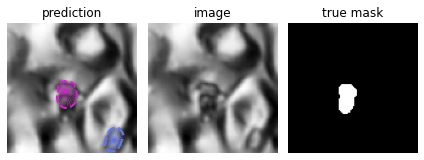

#17, image shape: (100, 100, 1), mask shape: (100, 100)
        image type: uint8, mask type: uint8


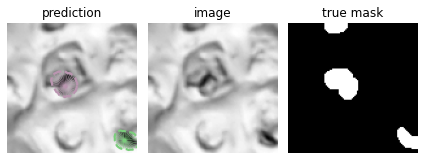

#90, image shape: (100, 100, 1), mask shape: (100, 100)
        image type: uint8, mask type: uint8


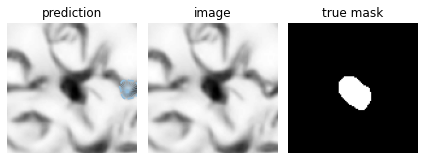

#92, image shape: (100, 100, 1), mask shape: (100, 100)
        image type: uint8, mask type: uint8


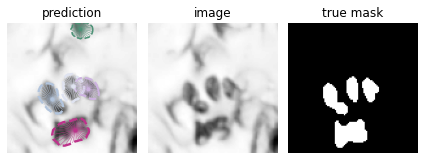

#50, image shape: (100, 100, 1), mask shape: (100, 100)
        image type: uint8, mask type: uint8


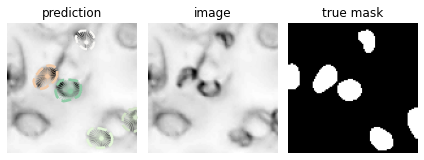

In [36]:
## show predictions examples
sample_index_lst = sample(list(range(len(X_val))), 5)

for ind in sample_index_lst:
  img = X_val[ind]
  msk = y_val[ind]
  print(f'#{ind}, image shape: {img.shape}, mask shape: {msk.shape}')
  print(f'        image type: {img.dtype}, mask type: {msk.dtype}')
  example(model,img,msk,show_dist=True)

In [37]:
## make predictions
y_test_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in X_val]

base.py (394): Predicting on non-float input... ( forgot to normalize? )


###evaluation

In [42]:
def compute_iou(y_pred, y_true):
  ious_0 = []
  ious_1 = []
  ious = []
  for i,j in zip(y_pred, y_true):
    pred = np.array(i > 0, dtype = int)
    true = np.array(j == 255, dtype = int)

    # ytrue, ypred is a flatten vector
    pred_ = pred.flatten()
    true_ = true.flatten()

    labels = [0, 1]
    jaccards = []

    jaccard_0 = jaccard_score(pred_.flatten(),true_.flatten(), pos_label=0)
    jaccard_1 = jaccard_score(pred_.flatten(),true_.flatten(), pos_label=1)
    
    ious_0.append(jaccard_0)
    ious_1.append(jaccard_1)
    ious.append((jaccard_0 + jaccard_1)/2)

  iou_0 = np.mean(jaccard_0)
  iou_1 = np.mean(jaccard_1)
  
  print(f'mean IoU of background: {np.mean(iou_0)}')
  print(f'median IoU of background: {np.median(iou_0)}')

  plt.hist(ious_0) ; plt.title('background IoU') ; plt.xlabel('sample Jaccard score') ; plt.ylabel('number of samples')
  plt.show()

  print(f'mean IoU of spores: {np.mean(iou_1)}')
  print(f'median IoU of spores: {np.median(iou_1)}')

  plt.hist(ious_1) ; plt.title('spores IoU') ; plt.xlabel('sample Jaccard score') ; plt.ylabel('number of samples')
  plt.show()

  print(f'mean IoU: {np.mean(ious)}')
  print(f'median IoU: {np.median(ious)}')

  plt.hist(ious) ; plt.title('model IoU') ; plt.xlabel('sample Jaccard score') ; plt.ylabel('number of samples')
  plt.show()


mean IoU of background: 0.9388111888111889
median IoU of background: 0.9388111888111889


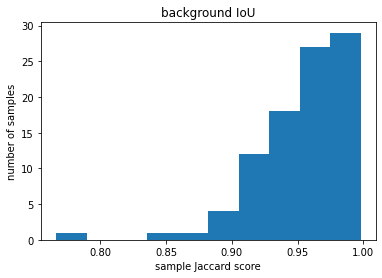

mean IoU of spores: 0.6022727272727273
median IoU of spores: 0.6022727272727273


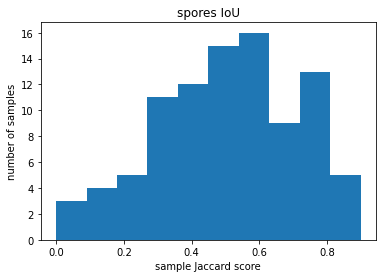

mean IoU: 0.7306820881100408
median IoU: 0.7387253603212035


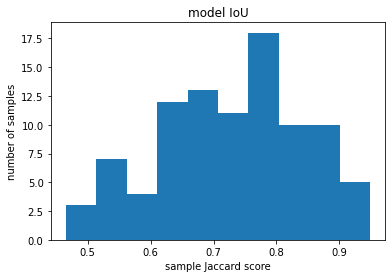

In [43]:
compute_iou(y_test_pred, y_val)